# 2. Streaming application using Spark Structured Streaming (55%)
## In this task, we will implement Spark Structured Streaming to consume the data from task 1 and perform predictive analytics.

Important:
- In this task, use PySpark Structured Streaming together with PySpark
Dataframe APIs and PySpark ML
- You are also provided with a pre-trained pipeline model for predicting the
top-up customers. Information on the required inputs of the pipeline model can
be found in the Background section

## 1. Write code to SparkSession is created using a SparkConf object, which would use two local cores with a proper application name, and use UTC as the timezone.

In [3]:
#using a SparkConf object 
#copy from week 10 lab task 1._Spark_Streaming_-_ClickStream-Analysis_DEMO_[V_1.1]
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

conf = SparkConf().setAppName("Assignment-2B-Task2_spark_streaming").setMaster("local[*]").set('spark.sql.session.timeZone','UTC') #set timezone as UTC
spark = SparkSession.builder.config(conf = conf).getOrCreate()


## 2. Use the same topic names from the Kafka producer in Task 1, ingest the streaming data into Spark Streaming and assume all data coming in String format.

Connection to Kafka Producer/Broker and subscribe to the topic and load data from Kafka topic with readStream

### on customer:

In [4]:
#copy from week 10 lab task 1._Spark_Streaming_-_ClickStream-Analysis_DEMO_[V_1.1]
df_customer = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", 'customer_topic') \
    .load()
df_customer.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



See the output in the console to examine the data after casting to string

In [5]:
#copy from week 10 lab task 1._Spark_Streaming_-_ClickStream-Analysis_DEMO_[V_1.1]

query = df_customer \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime = '5 seconds' ) \
    .start()


In [6]:
query.stop()

In [7]:
df_customer.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



### on bureau

In [8]:
df_bureau = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", 'bureau_topic') \
    .load()
df_bureau.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



## 3. Then the streaming data format should be transformed into the proper formats following the metadata file schema, similar to assignment 2A. Then use 'ts' column as the watermark and set the delay threshold to 5 seconds.

Converting the key/value from the kafka data stream to string

In [9]:
df_customer = df_customer.selectExpr("CAST(value AS STRING)") #only get value column
df_bureau=df_bureau.selectExpr("CAST(value AS STRING)") 

### change schema consumer

In [10]:
consumer_schema = ArrayType(StructType([
        StructField('ID' ,StringType(),True),
        StructField ('Frequency' ,StringType () , True),
        StructField('InstlmentMode',StringType(),True),
        StructField ('LoanStatus',StringType () , True),
        StructField ( 'PaymentMode',StringType(), True),
        StructField( 'BranchID' , StringType(), True),
        StructField( 'Area' , StringType(), True) ,
        StructField( 'Tenure', IntegerType(),True),
        StructField ( 'AssetCost', DoubleType() , True) ,
        StructField( 'AmountFinance' ,DoubleType () ,True),
        StructField ('DisbursalAmount' ,DoubleType (), True) ,
        StructField ('EMI' ,DoubleType () , True) ,
        StructField( 'DisbursalDate', StringType () ,True),
        StructField ( 'MaturityDAte' ,StringType () ,True),
        StructField( 'AuthDate' ,StringType (), True),
        StructField ( 'AssetID' ,StringType (), True),
        StructField ( 'ManufacturerID' ,StringType (), True),
        StructField( 'SupplierID' , StringType (), True),
        StructField('LTV',DoubleType () , True) ,
        StructField ('SEX' , StringType (), True) ,
        StructField( 'AGE' , DoubleType () ,True) ,
        StructField ( 'MonthlyIncome', DoubleType() ,True) ,
        StructField( 'City' , StringType () , True) ,
        StructField('State', StringType (), True),
        StructField('ZiPCODE',StringType () , True) ,
        StructField ('Top-up Month', StringType (),True) ,
        StructField('ts', IntegerType (), True)
    ]))

Use from_json to parse the string to the json format based on the defined schema.

In [11]:
#copy from week 10 lab task 1._Spark_Streaming_-_ClickStream-Analysis_DEMO_[V_1.1]
df_json_customer=df_customer \
    .select(from_json(col("value") \
    .cast("string"), consumer_schema) \
    .alias('parsed_value'))
    

In [12]:
df_json_customer.printSchema()

root
 |-- parsed_value: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ID: string (nullable = true)
 |    |    |-- Frequency: string (nullable = true)
 |    |    |-- InstlmentMode: string (nullable = true)
 |    |    |-- LoanStatus: string (nullable = true)
 |    |    |-- PaymentMode: string (nullable = true)
 |    |    |-- BranchID: string (nullable = true)
 |    |    |-- Area: string (nullable = true)
 |    |    |-- Tenure: integer (nullable = true)
 |    |    |-- AssetCost: double (nullable = true)
 |    |    |-- AmountFinance: double (nullable = true)
 |    |    |-- DisbursalAmount: double (nullable = true)
 |    |    |-- EMI: double (nullable = true)
 |    |    |-- DisbursalDate: string (nullable = true)
 |    |    |-- MaturityDAte: string (nullable = true)
 |    |    |-- AuthDate: string (nullable = true)
 |    |    |-- AssetID: string (nullable = true)
 |    |    |-- ManufacturerID: string (nullable = true)
 |    |    |-- SupplierID: strin

In [13]:
#copy from week 10 lab task 4._Clickstream_Spark_Streaming_-_Handling_Json_Array_DEMO
#use the explode function to flatten it.
df_json_explode_customer = df_json_customer\
    .select(explode(col('parsed_value')).alias('unnested_value'))\
    .select('unnested_value.*')

In [14]:
df_json_explode_customer.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- InstlmentMode: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- BranchID: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- AssetCost: double (nullable = true)
 |-- AmountFinance: double (nullable = true)
 |-- DisbursalAmount: double (nullable = true)
 |-- EMI: double (nullable = true)
 |-- DisbursalDate: string (nullable = true)
 |-- MaturityDAte: string (nullable = true)
 |-- AuthDate: string (nullable = true)
 |-- AssetID: string (nullable = true)
 |-- ManufacturerID: string (nullable = true)
 |-- SupplierID: string (nullable = true)
 |-- LTV: double (nullable = true)
 |-- SEX: string (nullable = true)
 |-- AGE: double (nullable = true)
 |-- MonthlyIncome: double (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZiPCODE: string (nullab

In [15]:
#copy from week 10 lab task 1._Spark_Streaming_-_ClickStream-Analysis_DEMO_[V_1.1]
query = df_json_explode_customer \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

In [16]:
query.stop()

In [17]:
#watermark need data as timestype sp ts change to timestype
df_json_explode_customer_ts_to_timestype = df_json_explode_customer\
    .withColumn("ts",col('ts').cast(TimestampType()))\
    .withWatermark("ts", "5 seconds")
    #.withColumnRenamed('ID', 'customerID')


In [18]:
df_json_explode_customer_ts_to_timestype.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- InstlmentMode: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- BranchID: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- AssetCost: double (nullable = true)
 |-- AmountFinance: double (nullable = true)
 |-- DisbursalAmount: double (nullable = true)
 |-- EMI: double (nullable = true)
 |-- DisbursalDate: string (nullable = true)
 |-- MaturityDAte: string (nullable = true)
 |-- AuthDate: string (nullable = true)
 |-- AssetID: string (nullable = true)
 |-- ManufacturerID: string (nullable = true)
 |-- SupplierID: string (nullable = true)
 |-- LTV: double (nullable = true)
 |-- SEX: string (nullable = true)
 |-- AGE: double (nullable = true)
 |-- MonthlyIncome: double (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZiPCODE: string (nullab

work on bureau

In [19]:
bureau_schema = ArrayType(StructType([
        StructField('ID', DoubleType(), True), 
        StructField('SELF-INDICATOR', BooleanType(), True),
        StructField('MATCH-TYPE', StringType(), True),
        StructField('ACCT-TYPE', StringType(), True),
        StructField('CONTRIBUTOR-TYPE', StringType(), True),
        StructField('DATE-REPORTED', StringType(), True),
        StructField('OWNERSHIP-IND', StringType(), True),
        StructField('ACCOUNT-STATUS', StringType(), True),
        StructField('DISBURSED-DT', StringType(), True),
        StructField('CLOSE-DT', StringType(), True),
        StructField('LAST-PAYMENT-DATE', StringType(), True),
        StructField('CREDIT-LIMIT/SANC AMT', StringType(), True),
        StructField('DISBURSED-AMT/HIGH CREDIT', StringType(), True),
        StructField('INSTALLMENT-AMT', StringType(), True),
        StructField('CURRENT-BAL', StringType(), True),
        StructField('INSTALLMENT-FREQUENCY', StringType(), True),
        StructField('OVERDUE-AMT', StringType(), True),
        StructField('WRITE-OFF-AMT', DoubleType(), True),
        StructField('ASSET_CLASS', StringType(), True),
        StructField('REPORTED DATE - HIST', StringType(), True),
        StructField('DPD - HIST', StringType(), True),
        StructField('CUR BAL - HIST', StringType(), True),
        StructField('AMT OVERDUE - HIST', StringType(), True),
        StructField('AMT PAID - HIST', StringType(), True),
        StructField('TENURE', DoubleType(), True),
        StructField('ts', IntegerType(), True)]))

df_jsondf_bureau=df_bureau \
    .select(from_json(col("value") \
    .cast("string"), bureau_schema) \
    .alias('parsed_value'))

df_json_explode_bureau = df_jsondf_bureau\
    .select(explode(col('parsed_value')).alias('unnested_value'))\
    .select('unnested_value.*')

df_json_explode_bureau_ts_to_timestype = df_json_explode_bureau\
    .withColumn("ts",col('ts').cast(TimestampType()))\
    .withWatermark("ts", "5 seconds")\
    .withColumn('SELF-INDICATOR',when(col('SELF-INDICATOR'),1).otherwise(0))
#Transform the “SELF-INDICATOR” column’s values.
df_json_explode_bureau_ts_to_timestype.printSchema()



root
 |-- ID: double (nullable = true)
 |-- SELF-INDICATOR: integer (nullable = false)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- DATE-REPORTED: string (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-DT: string (nullable = true)
 |-- CLOSE-DT: string (nullable = true)
 |-- LAST-PAYMENT-DATE: string (nullable = true)
 |-- CREDIT-LIMIT/SANC AMT: string (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: string (nullable = true)
 |-- INSTALLMENT-AMT: string (nullable = true)
 |-- CURRENT-BAL: string (nullable = true)
 |-- INSTALLMENT-FREQUENCY: string (nullable = true)
 |-- OVERDUE-AMT: string (nullable = true)
 |-- WRITE-OFF-AMT: double (nullable = true)
 |-- ASSET_CLASS: string (nullable = true)
 |-- REPORTED DATE - HIST: string (nullable = true)
 |-- DPD - HIST: string (nullable = true)
 |-- CUR BAL - HIST: string (nullab

## 4. Group the bureau stream based on ID with 30 seconds window duration, similar to assignment 2A(same rule for sum and dist).- Transform the “SELF-INDICATOR” column’s values. If the value is true, then convert to 1, if the value is false, then convert to 0. - sum the rows for numeric type columns, count distinct values for other columns with other data types, and rename them with the postfix like '_sum' or '_dist'. (For example, we did the sum function based on the 'HIGH CREDIT', and the new column’s name will be 'HIGH CREDIT_sum').

In [20]:
#copy from Ass2 part A
def changestrtoint(clo_str):
    if clo_str:
        b = ''.join([c for c in clo_str if c in '-1234567890'])
        return b
    return clo_str

In [21]:
#opy from Ass2 part A
changestrtointUDF = udf(lambda x:changestrtoint(x))

In [22]:
#opy from Ass2 part A
a = ['CREDIT-LIMIT/SANC AMT' ,'DISBURSED-AMT/HIGH CREDIT','INSTALLMENT-AMT','CURRENT-BAL','OVERDUE-AMT']

In [23]:
#opy from Ass2 part A
for i in a:
    df_json_explode_bureau_ts_to_timestype = df_json_explode_bureau_ts_to_timestype.withColumn(i,changestrtointUDF(col(i)).cast('double'))# have null value, use double

In [24]:
df_json_explode_bureau_ts_to_timestype.printSchema()

root
 |-- ID: double (nullable = true)
 |-- SELF-INDICATOR: integer (nullable = false)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- DATE-REPORTED: string (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-DT: string (nullable = true)
 |-- CLOSE-DT: string (nullable = true)
 |-- LAST-PAYMENT-DATE: string (nullable = true)
 |-- CREDIT-LIMIT/SANC AMT: double (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: double (nullable = true)
 |-- INSTALLMENT-AMT: double (nullable = true)
 |-- CURRENT-BAL: double (nullable = true)
 |-- INSTALLMENT-FREQUENCY: string (nullable = true)
 |-- OVERDUE-AMT: double (nullable = true)
 |-- WRITE-OFF-AMT: double (nullable = true)
 |-- ASSET_CLASS: string (nullable = true)
 |-- REPORTED DATE - HIST: string (nullable = true)
 |-- DPD - HIST: string (nullable = true)
 |-- CUR BAL - HIST: string (nullab

In [25]:
#copy from Ass2 part A
#merg = [sum(i[0]).alias(f'{i[0]}_sum') if i[1] in ['double', 'int '] 
        #else concat_ws(',',collect_set(i[0])).alias(f'{i[0]}_dist')for i in df_json_explode_bureau_ts_to_timestype.dtypes[1:-1]]
#merg

merg = [sum(i[0]).alias(f'{i[0]}_sum') if i[1] in ['double', 'int'] 
         else approx_count_distinct(i[0]).alias(f'{i[0]}_dist') for i in df_json_explode_bureau_ts_to_timestype.dtypes[1:-1]]
merg

[Column<b'sum(SELF-INDICATOR) AS `SELF-INDICATOR_sum`'>,
 Column<b'approx_count_distinct(MATCH-TYPE) AS `MATCH-TYPE_dist`'>,
 Column<b'approx_count_distinct(ACCT-TYPE) AS `ACCT-TYPE_dist`'>,
 Column<b'approx_count_distinct(CONTRIBUTOR-TYPE) AS `CONTRIBUTOR-TYPE_dist`'>,
 Column<b'approx_count_distinct(DATE-REPORTED) AS `DATE-REPORTED_dist`'>,
 Column<b'approx_count_distinct(OWNERSHIP-IND) AS `OWNERSHIP-IND_dist`'>,
 Column<b'approx_count_distinct(ACCOUNT-STATUS) AS `ACCOUNT-STATUS_dist`'>,
 Column<b'approx_count_distinct(DISBURSED-DT) AS `DISBURSED-DT_dist`'>,
 Column<b'approx_count_distinct(CLOSE-DT) AS `CLOSE-DT_dist`'>,
 Column<b'approx_count_distinct(LAST-PAYMENT-DATE) AS `LAST-PAYMENT-DATE_dist`'>,
 Column<b'sum(CREDIT-LIMIT/SANC AMT) AS `CREDIT-LIMIT/SANC AMT_sum`'>,
 Column<b'sum(DISBURSED-AMT/HIGH CREDIT) AS `DISBURSED-AMT/HIGH CREDIT_sum`'>,
 Column<b'sum(INSTALLMENT-AMT) AS `INSTALLMENT-AMT_sum`'>,
 Column<b'sum(CURRENT-BAL) AS `CURRENT-BAL_sum`'>,
 Column<b'approx_count_dist

In [26]:
#copy from week 11 lab 1._Spark_Streaming_Watermarking_DEMO_[V_1.1]
bureau_windowedCounts = df_json_explode_bureau_ts_to_timestype \
    .groupBy(window(df_json_explode_bureau_ts_to_timestype.ts, "30 seconds"),df_json_explode_bureau_ts_to_timestype.ID)\
    .agg(*merg)

In [27]:
bureau_windowedCounts.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- ID: double (nullable = true)
 |-- SELF-INDICATOR_sum: long (nullable = true)
 |-- MATCH-TYPE_dist: long (nullable = false)
 |-- ACCT-TYPE_dist: long (nullable = false)
 |-- CONTRIBUTOR-TYPE_dist: long (nullable = false)
 |-- DATE-REPORTED_dist: long (nullable = false)
 |-- OWNERSHIP-IND_dist: long (nullable = false)
 |-- ACCOUNT-STATUS_dist: long (nullable = false)
 |-- DISBURSED-DT_dist: long (nullable = false)
 |-- CLOSE-DT_dist: long (nullable = false)
 |-- LAST-PAYMENT-DATE_dist: long (nullable = false)
 |-- CREDIT-LIMIT/SANC AMT_sum: double (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT_sum: double (nullable = true)
 |-- INSTALLMENT-AMT_sum: double (nullable = true)
 |-- CURRENT-BAL_sum: double (nullable = true)
 |-- INSTALLMENT-FREQUENCY_dist: long (nullable = false)
 |-- OVERDUE-AMT_sum: double (nullable = true)
 |-- WRITE-OFF-AMT_sum: double

In [28]:
query = bureau_windowedCounts \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

In [29]:
query.stop()

## 5. Create new columns named 'window_start' and 'window_end' which are the window’s start time and end time in 2.4. Then inner join the 2 streams based on 'ID', and only customer data received between the window time are accepted. For example, customer data ID '3' received at 10:00, and only when the window of corresponding bureau data contains 10:00(like window start: 9:59, end: 10:00), then this data is accepted.

In [30]:
#copy from week 8 Collaborative filtering_update
#https://skytowner.com/explore/pyspark_column_getitem_method
# getItem can get sub root data by use key
bureau_windowedCounts_Create_new_columns = bureau_windowedCounts \
    .withColumn('window_start', col('window').getItem('start'))\
    .withColumn('window_end', col('window').getItem('end'))\
    .withColumnRenamed('ID', 'bureauID')


In [31]:
bureau_windowedCounts_Create_new_columns.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- bureauID: double (nullable = true)
 |-- SELF-INDICATOR_sum: long (nullable = true)
 |-- MATCH-TYPE_dist: long (nullable = false)
 |-- ACCT-TYPE_dist: long (nullable = false)
 |-- CONTRIBUTOR-TYPE_dist: long (nullable = false)
 |-- DATE-REPORTED_dist: long (nullable = false)
 |-- OWNERSHIP-IND_dist: long (nullable = false)
 |-- ACCOUNT-STATUS_dist: long (nullable = false)
 |-- DISBURSED-DT_dist: long (nullable = false)
 |-- CLOSE-DT_dist: long (nullable = false)
 |-- LAST-PAYMENT-DATE_dist: long (nullable = false)
 |-- CREDIT-LIMIT/SANC AMT_sum: double (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT_sum: double (nullable = true)
 |-- INSTALLMENT-AMT_sum: double (nullable = true)
 |-- CURRENT-BAL_sum: double (nullable = true)
 |-- INSTALLMENT-FREQUENCY_dist: long (nullable = false)
 |-- OVERDUE-AMT_sum: double (nullable = true)
 |-- WRITE-OFF-AMT_sum: 

according to the customer id to find the ts, with the same id in bureau,id customer ts in range bureau start and end ts,then we use inner join.



Handling Event-time and Late Data

Event-time is the time embedded in the data itself. For many applications, you may want to operate on this event-time. For example, if you want to get the number of events generated by IoT devices every minute, then you probably want to use the time when the data was generated (that is, event-time in the data), rather than the time Spark receives them. This event-time is very naturally expressed in this model – each event from the devices is a row in the table, and event-time is a column value in the row. This allows window-based aggregations (e.g. number of events every minute) to be just a special type of grouping and aggregation on the event-time column – each time window is a group and each row can belong to multiple windows/groups. Therefore, such event-time-window-based aggregation queries can be defined consistently on both a static dataset (e.g. from collected device events logs) as well as on a data stream, making the life of the user much easier.

Furthermore, this model naturally handles data that has arrived later than expected based on its event-time. Since Spark is updating the Result Table, it has full control over updating old aggregates when there is late data, as well as cleaning up old aggregates to limit the size of intermediate state data. Since Spark 2.1, we have support for watermarking which allows the user to specify the threshold of late data, and allows the engine to accordingly clean up old state. These are explained later in more detail in the Window Operations section.

#### Note:

we cant use aggregation before join. because in kafka, when we resive the data, according to the same number batch, there are 5 seconds delay. which means customer ids in one recive is different than aggregation.

the aggregation create by 30 seconds window. The aggregation window for the first 30 seconds is empty, and we need to wait for delay's data to be transmitted

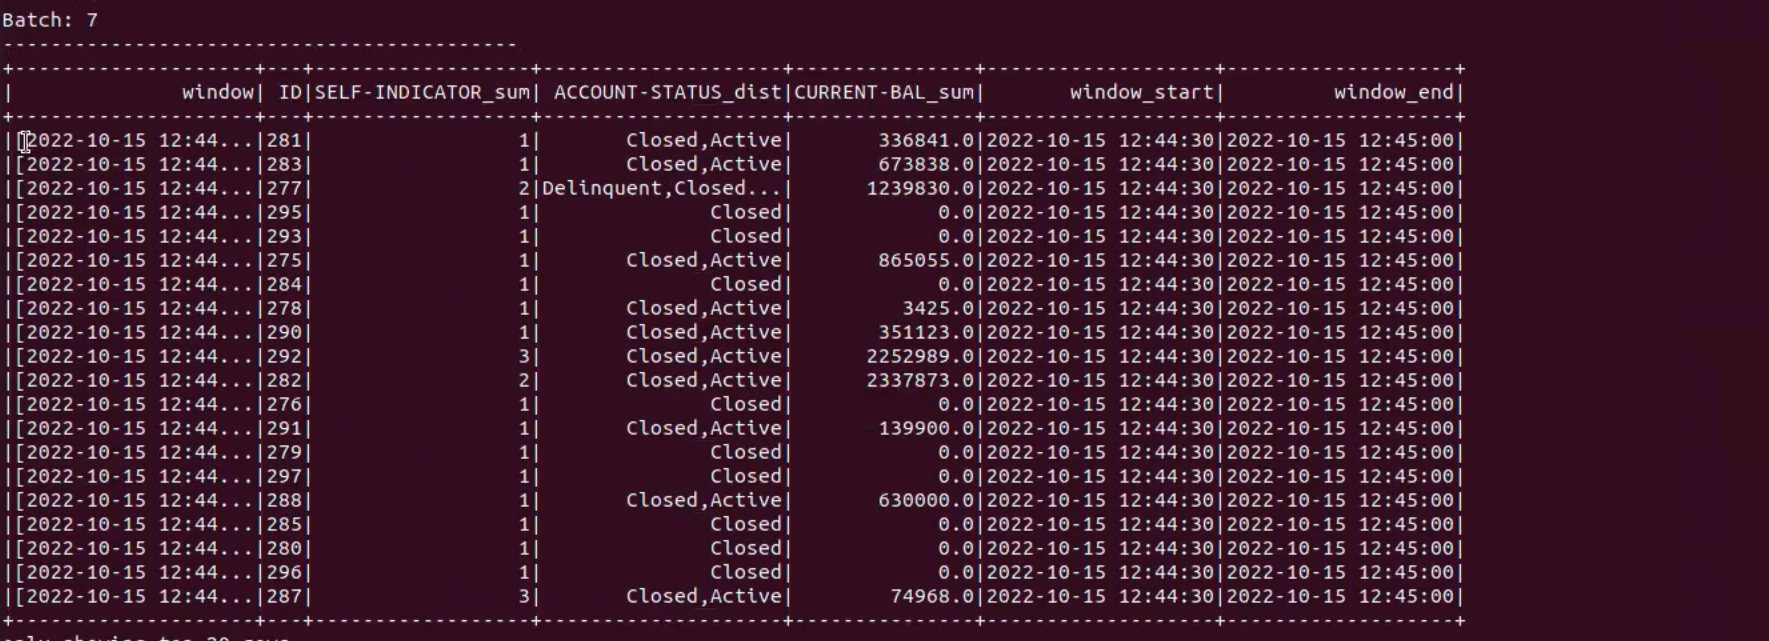
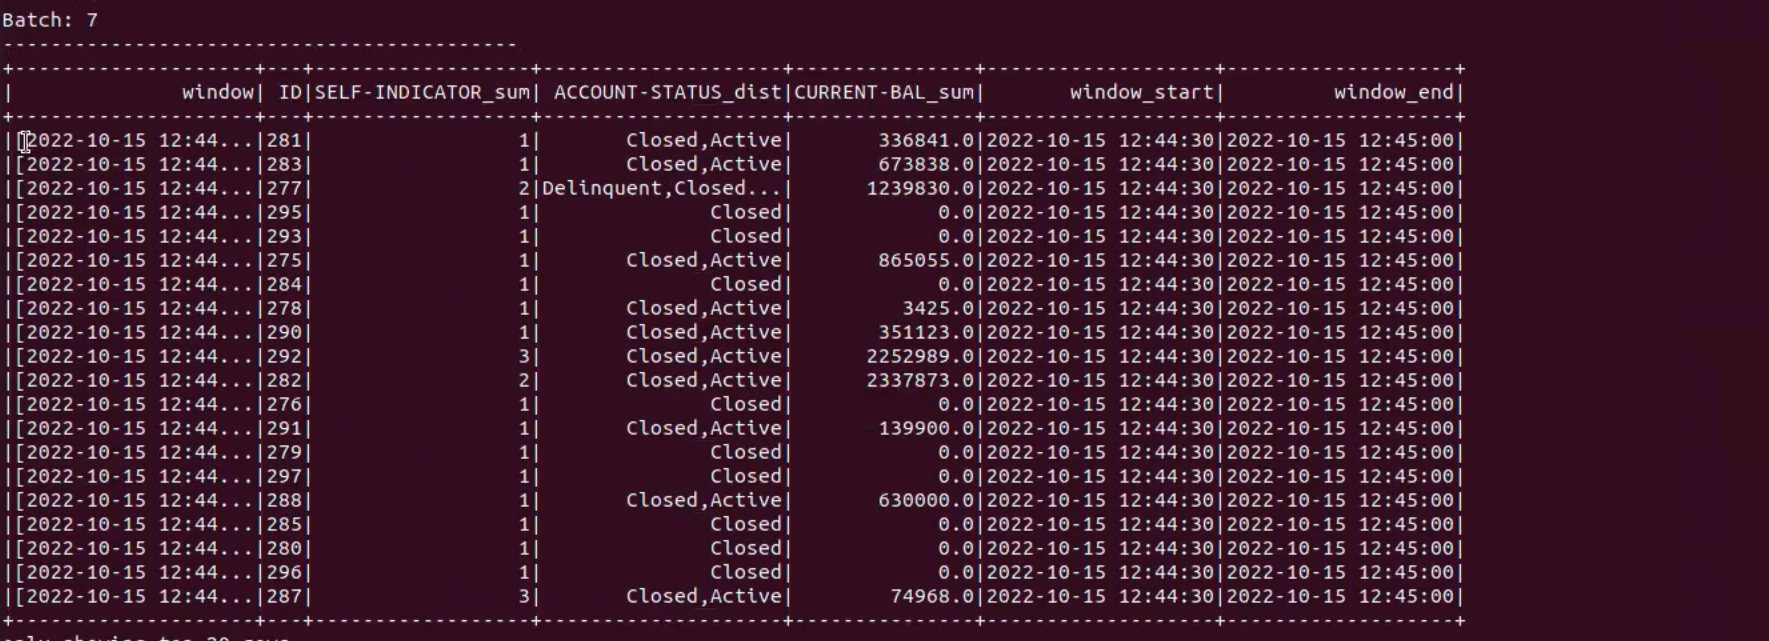

In [32]:
#The solution have two choices :
#first store the data in the sink for join, link to week 11 1._Spark_Streaming_Watermarking_DEMO_[V_1.1]
#second: https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#support-matrix-for-joins-in-streaming-queries
#example:
#df.createOrReplaceTempView("updates")
#spark.sql("select count(*) from updates")  # returns another streaming DF
df_json_explode_customer_ts_to_timestype.createOrReplaceTempView("DF_to_sql_customer")
bureau_windowedCounts_Create_new_columns.createOrReplaceTempView("DF_to_sql_bureau")

In [33]:
customer_bureau = spark.sql('''
SELECT *
FROM DF_to_sql_bureau,
DF_to_sql_customer
WHERE bureauID=ID
AND ts >= window_start
      AND ts <= window_end
'''
)


In [34]:
customer_bureau.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- bureauID: double (nullable = true)
 |-- SELF-INDICATOR_sum: long (nullable = true)
 |-- MATCH-TYPE_dist: long (nullable = false)
 |-- ACCT-TYPE_dist: long (nullable = false)
 |-- CONTRIBUTOR-TYPE_dist: long (nullable = false)
 |-- DATE-REPORTED_dist: long (nullable = false)
 |-- OWNERSHIP-IND_dist: long (nullable = false)
 |-- ACCOUNT-STATUS_dist: long (nullable = false)
 |-- DISBURSED-DT_dist: long (nullable = false)
 |-- CLOSE-DT_dist: long (nullable = false)
 |-- LAST-PAYMENT-DATE_dist: long (nullable = false)
 |-- CREDIT-LIMIT/SANC AMT_sum: double (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT_sum: double (nullable = true)
 |-- INSTALLMENT-AMT_sum: double (nullable = true)
 |-- CURRENT-BAL_sum: double (nullable = true)
 |-- INSTALLMENT-FREQUENCY_dist: long (nullable = false)
 |-- OVERDUE-AMT_sum: double (nullable = true)
 |-- WRITE-OFF-AMT_sum: 

## 6. Persist the above result in parquet format.(When you save the data to parquet format,you need to rename “Top-up Month” to “Top-up_Month” first. And only keep these columns “ID”, “window_start”, “window_end”, “ts”, “Top-up_Month”) Renaming “Top-up Month” only happen in this question


In [35]:
customer_bureau26 = customer_bureau.withColumnRenamed("Top-up Month", "Top-up_Month")

In [36]:
customer_bureau26.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- bureauID: double (nullable = true)
 |-- SELF-INDICATOR_sum: long (nullable = true)
 |-- MATCH-TYPE_dist: long (nullable = false)
 |-- ACCT-TYPE_dist: long (nullable = false)
 |-- CONTRIBUTOR-TYPE_dist: long (nullable = false)
 |-- DATE-REPORTED_dist: long (nullable = false)
 |-- OWNERSHIP-IND_dist: long (nullable = false)
 |-- ACCOUNT-STATUS_dist: long (nullable = false)
 |-- DISBURSED-DT_dist: long (nullable = false)
 |-- CLOSE-DT_dist: long (nullable = false)
 |-- LAST-PAYMENT-DATE_dist: long (nullable = false)
 |-- CREDIT-LIMIT/SANC AMT_sum: double (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT_sum: double (nullable = true)
 |-- INSTALLMENT-AMT_sum: double (nullable = true)
 |-- CURRENT-BAL_sum: double (nullable = true)
 |-- INSTALLMENT-FREQUENCY_dist: long (nullable = false)
 |-- OVERDUE-AMT_sum: double (nullable = true)
 |-- WRITE-OFF-AMT_sum: 

In [37]:
customer_bureau_query = customer_bureau26 \
        .select('ID', 'window_start', 'window_end', 'ts', 'Top-up_Month') \
        .writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "parquet/clickstream_df")\
        .option("checkpointLocation", "parquet/clickstream_df/checkpoint")\
        .start()

In [38]:
customer_bureau_query.stop()

In [39]:
customer_bureau_query_sink = spark.read.parquet("parquet/clickstream_df")
customer_bureau_query_sink.printSchema()
customer_bureau_query_sink.show()

root
 |-- ID: string (nullable = true)
 |-- window_start: timestamp (nullable = true)
 |-- window_end: timestamp (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- Top-up_Month: string (nullable = true)

+------+-------------------+-------------------+-------------------+-----------------+
|    ID|       window_start|         window_end|                 ts|     Top-up_Month|
+------+-------------------+-------------------+-------------------+-----------------+
|113473|2022-10-20 15:54:30|2022-10-20 15:55:00|2022-10-20 15:54:42|No Top-up Service|
|100549|2022-10-20 15:55:00|2022-10-20 15:55:30|2022-10-20 15:55:17|No Top-up Service|
|135172|2022-10-20 15:53:30|2022-10-20 15:54:00|2022-10-20 15:53:56|No Top-up Service|
|140226|2022-10-20 15:53:30|2022-10-20 15:54:00|2022-10-20 15:53:46|No Top-up Service|
|122085|2022-10-20 15:53:30|2022-10-20 15:54:00|2022-10-20 15:53:31|No Top-up Service|
|123355|2022-10-20 15:54:00|2022-10-20 15:54:30|2022-10-20 15:54:01|No Top-up Service|
|100

## 7. Load the machine learning models given and use the model to predict whether users will be joining the top-up service. Save the results in parquet format. (When you save the data to parquet format,you need to rename “Top-up Month” to “Top-up_Month” first. And only keep these columns “ID”, “window_start”, “window_end”, “ts”, “prediction”, “Top-up_Month”) Renaming “Top-up Month” will happen in this question as well

In [40]:
from pyspark.ml import PipelineModel

In [41]:
#loda the pipeline model
customer_bureau_topup_pipeline_model=PipelineModel.load("topup_pipeline_model")

In [42]:
#transform data in the model
prediction=customer_bureau_topup_pipeline_model.transform(customer_bureau26)

In [43]:
prediction=prediction.withColumnRenamed("Top-up Month", "Top-up_Month")

In [44]:
#coding from week11 lab
# Write into parquet files the unsuccessful requests partitioned by status code
customer_bureau_query27 = prediction \
        .select('ID', 'window_start', 'window_end', 'ts', 'Top-up_Month') \
        .writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "parquet/clickstream_df")\
        .option("checkpointLocation", "parquet/clickstream_df/checkpoint")\
        .start()

In [45]:
machine_learning_models_sink_df = spark.read.parquet("parquet/clickstream_df")
machine_learning_models_sink_df.printSchema()
machine_learning_models_sink_df.show()

root
 |-- ID: string (nullable = true)
 |-- window_start: timestamp (nullable = true)
 |-- window_end: timestamp (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- Top-up_Month: string (nullable = true)

+------+-------------------+-------------------+-------------------+-----------------+
|    ID|       window_start|         window_end|                 ts|     Top-up_Month|
+------+-------------------+-------------------+-------------------+-----------------+
|113473|2022-10-20 15:54:30|2022-10-20 15:55:00|2022-10-20 15:54:42|No Top-up Service|
|100549|2022-10-20 15:55:00|2022-10-20 15:55:30|2022-10-20 15:55:17|No Top-up Service|
|135172|2022-10-20 15:53:30|2022-10-20 15:54:00|2022-10-20 15:53:56|No Top-up Service|
|140226|2022-10-20 15:53:30|2022-10-20 15:54:00|2022-10-20 15:53:46|No Top-up Service|
|122085|2022-10-20 15:53:30|2022-10-20 15:54:00|2022-10-20 15:53:31|No Top-up Service|
|123355|2022-10-20 15:54:00|2022-10-20 15:54:30|2022-10-20 15:54:01|No Top-up Service|
|100

In [46]:
customer_bureau_query27.stop()

## 8. Only keep the customer predicted as our target customers (willing to join the top-up service). Normally, we should only keep “Top-up=1”. But due to the limited performance of our VM, if your process is extremely slow, you can abandon the filter and keep all of the data. Then for each batch, show the epoch id and count of the dataframe. If the dataframe is not empty, transform the data to the following key/value format, which key is 'window_end' column and the data are the numbers of top-up services customers in the different states(in JSON format). Then send it to Kafka with a proper topic. These data will be used for the real-time monitoring in task 3.

In [47]:
from json import dumps   #convert a subset of Python objects into a json string
from kafka import KafkaProducer

In [48]:
#coding from week 9 lab
def publish_message(producer_instance, topic_name, data):
    try:
        producer_instance.send(topic_name, data)
        print('Message published successfully. Data: ' + str(data))
    except Exception as ex:
        print('Exception in publishing message.')
        print(str(ex))
        
def connect_kafka_producer():
    _producer = None
    try:
        _producer = KafkaProducer(bootstrap_servers=['localhost:9092'],
                                  value_serializer=lambda x: dumps(x).encode('ascii'),
                                  api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka.')
        print(str(ex))
    finally:
        return _producer

In [49]:
producer=connect_kafka_producer()

In [50]:
def batch_function(df,epoch_id):
    count = df.select("ID").count() #number of rows in the DF
    print("epoch_id:"+str(epoch_id)) 
    print("count:"+str(length))
    if count!=0: # think about the time delay
        send= df.groupBy("State").count().toJSON().collect() #to joson so we can save the count reslut in key pair format.
        publish_message(producer,"Assignment-2B-Task2_spark_streaming",send) #publish message
    else:
        send = "no message" 
        publish_message(producer,"Assignment-2B-Task2_spark_streaming",send_message) 

In [51]:
query28 = prediction \
    .filter(col("prediction")==1.0)\
    .writeStream \
    .outputMode("Append") \
    .foreachBatch(batch_function)\
    .start()


In [52]:
query28.stop()

epoch_id:0
count:<function length at 0x7f24db554ee0>
